Grover's Search Algorithm Details
------------------------------------------------------------
Target states: ['110000', '011011']
Number of qubits: 6
Number of target states: 2
Optimal number of iterations (k): 4
     ┌───┐ ░ ┌───┐       ┌───┐ ░             ┌───┐┌───┐            ┌───┐┌───┐»
q_0: ┤ H ├─░─┤ X ├─■─────┤ X ├─░───────■─────┤ H ├┤ X ├──────■─────┤ X ├┤ H ├»
     ├───┤ ░ ├───┤ │     ├───┤ ░       │     ├───┤├───┤      │     ├───┤├───┤»
q_1: ┤ H ├─░─┤ X ├─■─────┤ X ├─░───────■─────┤ H ├┤ X ├──────■─────┤ X ├┤ H ├»
     ├───┤ ░ ├───┤ │     ├───┤ ░ ┌───┐ │     ├───┤├───┤┌───┐ │     ├───┤├───┤»
q_2: ┤ H ├─░─┤ X ├─■─────┤ X ├─░─┤ X ├─■─────┤ X ├┤ H ├┤ X ├─■─────┤ X ├┤ H ├»
     ├───┤ ░ ├───┤ │     ├───┤ ░ └───┘ │     ├───┤├───┤└───┘ │     ├───┤├───┤»
q_3: ┤ H ├─░─┤ X ├─■─────┤ X ├─░───────■─────┤ H ├┤ X ├──────■─────┤ X ├┤ H ├»
     ├───┤ ░ └───┘ │     └───┘ ░       │     ├───┤├───┤      │     ├───┤├───┤»
q_4: ┤ H ├─░───────■───────────░───────■─────┤ H ├┤ X ├──────■─────┤ X ├┤ H

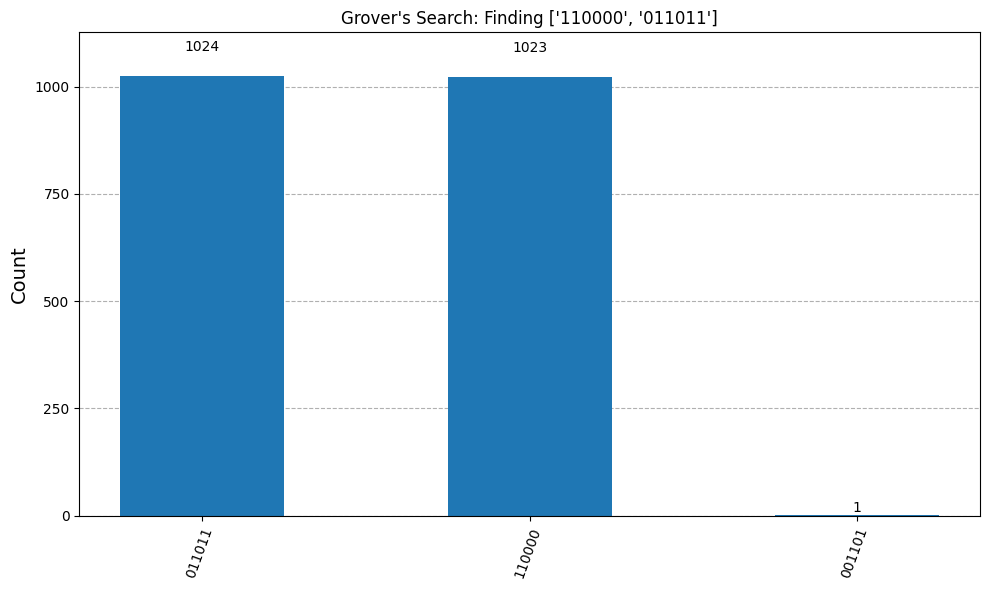


--- Analysis ---
As the histogram shows, the states 110000 and 011011 were measured with the highest probabilities,
successfully demonstrating the algorithm's ability to find the target items.
--- End of analysis ---


In [6]:
# =============================================================================
# Grover's Algorithm Implementation for Portfolio
#
# This script demonstrates a general implementation of Grover's search algorithm
# capable of finding multiple target states in a quantum database.
# =============================================================================

from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from typing import List

# It's good practice to enable matplotlib inline plotting at the top
%matplotlib inline


def get_zero_indices(bitstring: str) -> List[int]:
    """
    Identifies the indices corresponding to '0's in a bitstring.

    Args:
        bitstring: The classical bitstring to inspect.

    Returns:
        A list of integer indices where the bit is '0'. The indexing
        is right-to-left, mapping to Qiskit's qubit ordering.
    """
    return [i for i, bit in enumerate(reversed(bitstring)) if bit == '0']


def create_multi_state_oracle(keys: List[str]) -> QuantumCircuit:
    """
    Constructs a phase-flip oracle for a list of target computational basis states.

    Args:
        keys: A list of binary strings representing the target states.

    Returns:
        A QuantumCircuit object representing the oracle.
    """
    num_qubits = len(keys[0])
    # Give the circuit a descriptive name for better visualization
    oracle_circuit = QuantumCircuit(num_qubits, name="Oracle")

    for i, key in enumerate(keys):
        if i > 0:
            oracle_circuit.barrier()  # Visually separate oracles for each key

        # The core X-MCP-X sandwich to flip the phase of the target state
        zeros = get_zero_indices(key)
        if zeros:
            oracle_circuit.x(zeros)
        
        oracle_circuit.mcp(np.pi, list(range(num_qubits - 1)), num_qubits - 1)

        if zeros:
            oracle_circuit.x(zeros)

    return oracle_circuit


def create_diffuser(n: int) -> QuantumCircuit:
    """
    Constructs the Grover diffusion operator (inversion about the mean).

    Args:
        n: The number of qubits.

    Returns:
        A QuantumCircuit object representing the diffuser.
    """
    qc = QuantumCircuit(n, name="Diffuser")
    
    # Apply H-gates to change basis from computational to Hadamard
    qc.h(range(n))
    
    # Use the oracle construction to perform a phase-flip on the |0⟩^n state
    # This is equivalent to 2|0⟩⟨0| - I
    qc.compose(create_multi_state_oracle(['0' * n]), inplace=True)
    
    # Apply H-gates again to return to the computational basis
    qc.h(range(n))
    
    return qc


def build_grover_circuit(keys: List[str]) -> QuantumCircuit:
    """
    Assembles the full Grover's search algorithm circuit.

    Args:
        keys: A list of binary strings to search for.

    Returns:
        The complete, executable QuantumCircuit for the search.
    """
    num_qubits = len(keys[0])
    num_keys = len(keys)

    # Calculate the optimal number of Grover iterations
    num_iterations = round(np.pi / 4 * np.sqrt(2**num_qubits / num_keys))

    # --- Build the circuit ---
    qc = QuantumCircuit(num_qubits, num_qubits)
    
    # 1. Initialize state to uniform superposition
    qc.h(range(num_qubits))
    qc.barrier()

    # Get the necessary components
    oracle = create_multi_state_oracle(keys)
    diffuser = create_diffuser(num_qubits)
    
    # 2. Apply Grover operator k times
    for _ in range(num_iterations):
        qc.compose(oracle, inplace=True)
        qc.compose(diffuser, inplace=True)
        qc.barrier()
    
    # 3. Measure the results
    qc.measure(range(num_qubits), range(num_qubits))

    # --- Print helpful information for the portfolio viewer ---
    print("=" * 60)
    print("Grover's Search Algorithm Details")
    print("-" * 60)
    print(f"Target states: {keys}")
    print(f"Number of qubits: {num_qubits}")
    print(f"Number of target states: {num_keys}")
    print(f"Optimal number of iterations (k): {num_iterations}")
    print("=" * 60)
    print(qc)
    
    return qc


def main():
    """Main execution function."""
    
    # Define the states to find
    target_keys = ['110000', '011011']
    
    # Build the full quantum circuit
    grover_circuit = build_grover_circuit(target_keys)

    # --- Simulation ---
    simulator = AerSimulator()
    transpiled_circuit = transpile(grover_circuit, simulator)
    job = simulator.run(transpiled_circuit, shots=2048) # Using more shots for cleaner results
    result = job.result()
    counts = result.get_counts(transpiled_circuit)

    # --- Results and Visualization ---
    print("\nSimulation Results:")
    print("The histogram below shows the measurement outcomes.")
    print("A successful search will show sharp peaks at the target states.")
    
    # Create a more descriptive plot title
    plot_title = f"Grover's Search: Finding {target_keys}"
    plot_histogram(counts, title=plot_title, sort='value_desc', figsize=(10, 6))
    plt.show()

    # Add a concluding summary of the results
    print("\n--- Analysis ---")
    print(f"As the histogram shows, the states {target_keys[0]} and {target_keys[1]} were measured with the highest probabilities,")
    print("successfully demonstrating the algorithm's ability to find the target items.")
    print("--- End of analysis ---")


if __name__ == "__main__":
    main()